<a href="https://colab.research.google.com/github/zeellm/IEEE-RAS-workshop/blob/main/ieeerasworkshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/jesherjoshua/RAS-Workshop.git

fatal: destination path 'RAS-Workshop' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import matplotlib.image as mpimg

In [ ]:
df=pd.read_csv('/content/RAS-Workshop/data/pokemon.csv')

In [ ]:
data_path='/content/RAS-Workshop/data/images/'
df['filepath']=[data_path+i+'.png' for i in df['name']]

In [ ]:
df.head()

,name,type,filepath
0,bulbasaur,Grass,/content/RAS-Workshop/data/images/bulbasaur.png
1,ivysaur,Grass,/content/RAS-Workshop/data/images/ivysaur.png
2,venusaur,Grass,/content/RAS-Workshop/data/images/venusaur.png
3,charmander,Fire,/content/RAS-Workshop/data/images/charmander.png
4,charmeleon,Fire,/content/RAS-Workshop/data/images/charmeleon.png


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      809 non-null    object
 1   type      809 non-null    object
 2   filepath  809 non-null    object
dtypes: object(3)
memory usage: 19.1+ KB


In [ ]:
df.describe()

,name,type,filepath
count,809,809,809
unique,809,18,809
top,bulbasaur,Water,/content/RAS-Workshop/data/images/bulbasaur.png
freq,1,114,1


In [ ]:
df.isna().sum()

name        0
type        0
filepath    0
dtype: int64

In [ ]:
df.type.value_counts()

Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Dark         29
Fighting     29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: type, dtype: int64

<Axes: >

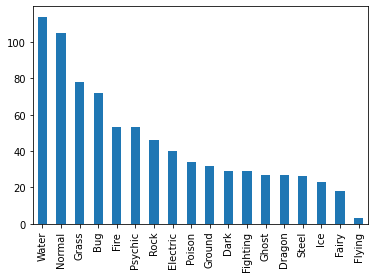

In [ ]:
df.type.value_counts().plot(kind='bar')

In [ ]:
df.name.nunique()

809

In [ ]:
len(df)

809

In [ ]:
df.nunique()

name        809
type         18
filepath    809
dtype: int64

<Axes: >

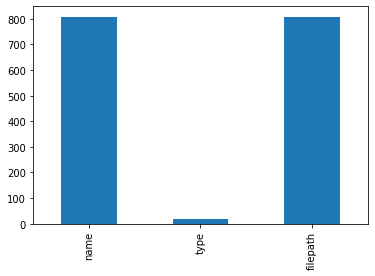

In [ ]:
df.nunique().plot(kind='bar')

In [ ]:
df=df.query("type=='Water' | type=='Fire'")
df.index=range(len(df))

In [ ]:
df['onehot']=tf.keras.utils.to_categorical(LabelEncoder().fit_transform(df.type)).tolist()

In [ ]:
len(df)

167

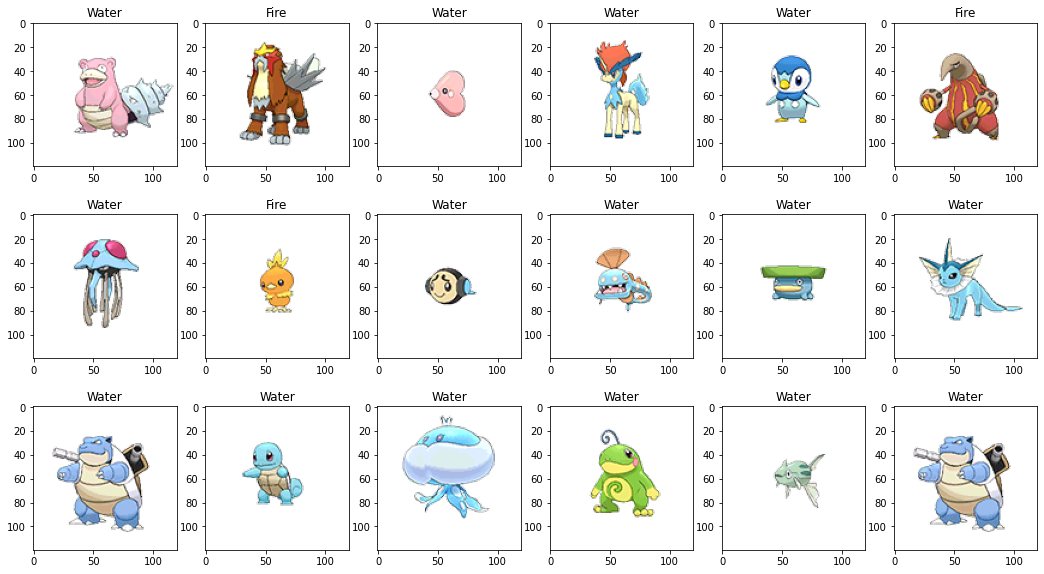

In [ ]:
fig,ax=plt.subplots(3,6,figsize=(18,10))

for i in range(3):
    for j in range(6):
        rand=np.random.randint(0,len(df)-1)
        ax[i,j].set_title(df.type[rand])
        ax[i,j].imshow(mpimg.imread(df.filepath[rand]))
     

In [ ]:
import tensorflow as tf
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,   
    rescale=1/255
)


train_data = train_gen.flow_from_dataframe(
    df,
    x_col='filepath',
    y_col='type',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='categorical',
    batch_size=32,
    seed=1,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    df,
    x_col='filepath',
    y_col='type',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='categorical',
    batch_size=32,
    seed=1,
    subset='validation'
)

Found 134 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.


In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(120,120,4)))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(2,activation='sigmoid'))

In [ ]:
model.compile(
    optimizer='adam',                 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
   metrics=['acc']
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 118, 118, 64)      2368      
                                                                 
 conv2d_19 (Conv2D)          (None, 116, 116, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 conv2d_21 (Conv2D)          (None, 54, 54, 128)       147584    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 27, 27, 128)      0         
 g2D)                                                 

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=32,
    epochs=100,  
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_acc',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
5/5 [==============================] - 38s 7s/step - loss: 0.7323 - acc: 0.4104 - val_loss: 0.6765 - val_acc: 0.7273 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 35s 7s/step - loss: 0.6718 - acc: 0.6716 - val_loss: 0.6005 - val_acc: 0.7273 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 37s 8s/step - loss: 0.6340 - acc: 0.6716 - val_loss: 0.5474 - val_acc: 0.7273 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 34s 7s/step - loss: 0.5417 - acc: 0.6716 - val_loss: 0.4502 - val_acc: 0.7273 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 36s 7s/step - loss: 0.4063 - acc: 0.7015 - val_loss: 0.2886 - val_acc: 0.8182 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 34s 7s/step - loss: 0.5023 - acc: 0.7239 - val_loss: 0.7058 - val_acc: 0.2424 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - 36s 9s/step - loss: 0.5771 - acc: 0.5821 - val_loss: 0.5012 - val_acc: 0.7576 - lr: 0.0010
Epoch 

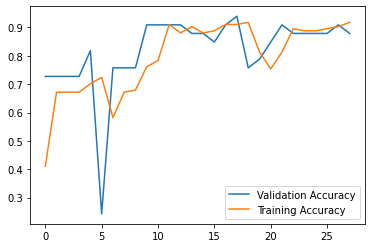

In [ ]:
plt.plot(history.history['val_acc'],label='Validation Accuracy')
plt.plot(history.history['acc'],label='Training Accuracy')
plt.legend()

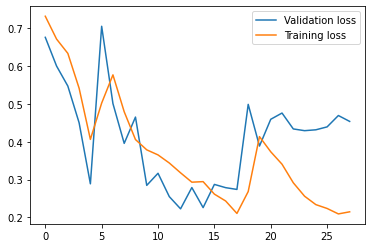

In [ ]:
plt.plot(history.history['val_loss'],label='Validation loss')
plt.plot(history.history['loss'],label='Training loss')
plt.legend()

In [ ]:
model.save('pokemonclassification.h5')

In [ ]:
img=mpimg.imread('/content/RAS-Workshop/data/images/bulbasaur.png')
np.squeeze(img).shape
out=np.argmax(model.predict(np.expand_dims(img,axis=0)))
print(out)

1/1 [==============================] - 0s 178ms/step
1


In [ ]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gradio as gr

In [ ]:
def classify(inp):
  new_image = np.zeros((120, 120, 4))
  new_image[:,:,0:3] = inp[:,:,:]
  model = tf.keras.models.load_model('pokemonclassifiaction.h5')
  prediction=np.argmax(model.predict(np.expand_dims(new_image,axis=0)))
  prediction=int(prediction)
  if prediction==1:
    return "Water"
  else:
    return "Fire"

In [115]:
gr.Interface(fn=classify, 
             inputs=gr.Image(shape=(120,120)),
             outputs=gr.Label(),
            share=True).launch()

/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:43: UserWarning: You have unused kwarg parameters in Interface, please remove them: {'share': True}
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>